# Illustration of Bayesian inference for a 2d Gaussian random vector z

### Importing probml_utils library

In [1]:
try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

  Cloning https://github.com/probml/probml-utils.git to /tmp/pip-req-build-khotuvno
  Running command git clone -q https://github.com/probml/probml-utils.git /tmp/pip-req-build-khotuvno
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 272 kB 3.2 MB/s 
     |████████████████████████████████| 72 kB 724 kB/s 
  Created wheel for probml-utils: filename=probml_utils-0.1.dev53+geea6bd7-py3-none-any.whl size=45129 sha256=9b8371a3ba0a6449e0f1f09ac22177c1aede440b74471e8ff7d53f70471a2259
  Stored in directory: /tmp/pip-ephem-wheel-cache-w_w5pj2b/wheels/37/8f/cb/b845cd5de3d7f648717815f9c27bec49975bf58637a97fa6be
  Created wheel for TexSoup: filename=TexSoup-0.3.1-py3-none-any.whl size=27666 sha256=7bc41ecd713558498455a48b63b86bc5eb4e39c65bec3896335ea0322faebcf1
  Stored in directory: /root/.cache/pip/wheels/2b/8e/c6/7ee3f9f9776fd18c0ccb04492902ed42225b6dfab3c68f14c0
  Created wheel

### Importing other libraries

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
from jax.numpy.linalg import cholesky
from jax.scipy.linalg import inv
from scipy.stats import multivariate_normal

### Set latexify params

In [3]:
latexify(width_scale_factor=3, fig_height=1.5)

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


### Function declarations

In [4]:
def gaussSample(mu, sigma, n, key):
    decomposition = cholesky(sigma)
    normal_distribution = jax.random.normal(key, shape=(len(mu), n))
    return jnp.dot(decomposition, normal_distribution).T + mu

In [5]:
def plot_data(x, muTrue, savename, title, fig=None, ax=None):
    marker_size = 4 if is_latexify_enabled() else None
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(x[:, 0], x[:, 1], "o", markerfacecolor="b")
    ax.set_ylim([-1, 1])
    ax.set_xlim([-1, 1])
    ax.set_title(title)
    ax.set_xlabel("$y_1$")
    ax.set_ylabel("$y_2$")
    ax.plot(muTrue[0], muTrue[1], "x", markerfacecolor="black", color="k")

    sns.despine()
    if len(savename) > 0:
        savefig(savename)
    return fig, ax

In [6]:
def make_contour_plot(x1, x2, p, savename, title, fig=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    contour = ax.contourf(x1, x2, p)
    fig.colorbar(contour, ax=ax)

    ax.set_ylim([-1, 1])
    ax.set_xlim([-1, 1])
    ax.set_title(title)
    ax.set_xlabel("$z_1$")
    ax.set_ylabel("$z_2$")
    plt.gca().set_aspect("equal")
    sns.despine()
    if len(savename) > 0:
        savefig(savename)
    return fig, ax

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:79: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f47604f2350>)

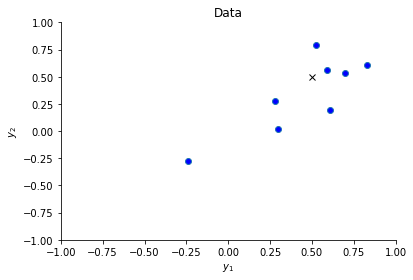

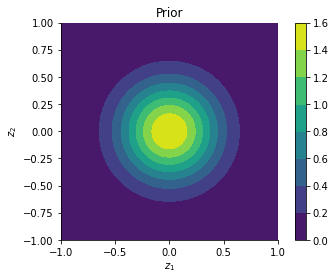

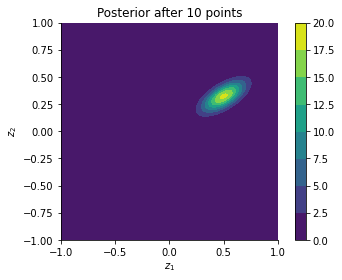

In [7]:
data = {}
prior = {}
post = {}
key = jax.random.PRNGKey(5)

n_points = 10  # number of sample data points

# Part A
z = jnp.array([0.5, 0.5])
sigma_data = 0.1 * jnp.array([[2, 1], [1, 1]])

data["mu"] = z
data["Sigma"] = sigma_data
sample_points = gaussSample(data["mu"], data["Sigma"], n_points, key)
plot_data(sample_points, z, "gauss_infer_2d_(a)", "Data")

# Part B
xyrange = jnp.array([[-1, 1], [-1, 1]])
npoints = 100j
prior["mu"] = jnp.array([0, 0])
prior["Sigma"] = 0.1 * jnp.eye(2)
mesh = jnp.mgrid[xyrange[0, 0] : xyrange[0, 1] : npoints, xyrange[1, 0] : xyrange[1, 1] : npoints]
x1, x2 = mesh[0], mesh[1]
points = jnp.vstack([jnp.ravel(x1), jnp.ravel(x2)]).T
prior_pdf = multivariate_normal.pdf(points, mean=prior["mu"], cov=prior["Sigma"]).reshape(x1.shape[0], x2.shape[0])

make_contour_plot(x1, x2, prior_pdf, "gauss_infer_2d_(b)", "Prior")

# Part C
data_after_n = sample_points[:n_points, :]
s0_inv = inv(prior["Sigma"])
s_inv = inv(sigma_data)
post["Sigma"] = inv(s0_inv + n_points * s_inv)
mean = jnp.mean(data_after_n, 0)
post["mu"] = jnp.dot(post["Sigma"], (jnp.dot(n_points, jnp.dot(s_inv, mean)) + jnp.dot(s0_inv, prior["mu"])))
post_pdf = multivariate_normal.pdf(points, mean=post["mu"], cov=post["Sigma"]).reshape(x1.shape[0], x2.shape[0])
make_contour_plot(x1, x2, post_pdf, "gauss_infer_2d_(c)", "Posterior after " + str(n_points) + " points")

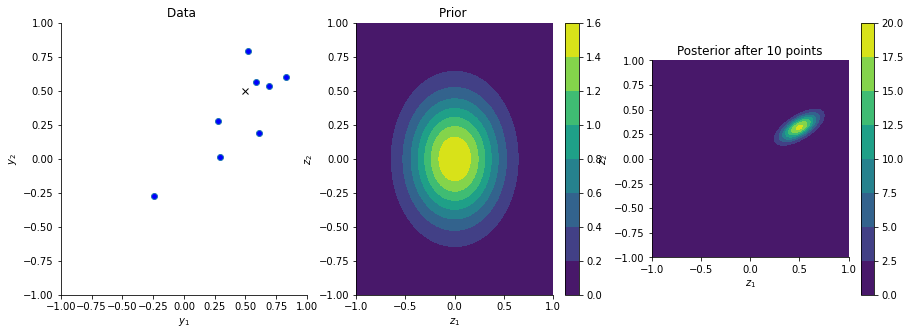

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
plot_data(sample_points, z, "", "Data ", fig=fig, ax=ax1)
make_contour_plot(x1, x2, prior_pdf, "", "Prior ", fig=fig, ax=ax2)
make_contour_plot(x1, x2, post_pdf, "", "Posterior after " + str(n_points) + " points", fig=fig, ax=ax3)
plt.show()

### Interactive plot

In [9]:
from ipywidgets import interact


@interact(random_state=(1, 10), n_=(1, 20))
def generate_random(random_state, n_=10):
    key = jax.random.PRNGKey(random_state)
    sample_points = gaussSample(data["mu"], data["Sigma"], n_, key)
    plot_data(sample_points, z, "", "Data")
    plt.show()

interactive(children=(IntSlider(value=5, description='random_state', max=10, min=1), IntSlider(value=10, descr…